# Introduction

The purpose of kernel is to forecast future changes in EUR/USD parity and develop a trade strategy which is profitable.


### Features

The features used for training model is mostly created by using technical analysis,
except COT report data which is used for creating fundemental analysis features.
Further information can be found about COT Report:
https://www.cftc.gov/MarketReports/CommitmentsofTraders/index.htm
https://www.investopedia.com/terms/c/cot.asp 

For techincal analysis library I used https://mrjbq7.github.io/ta-lib/

### Machine Learning Algorithm

Lightgbm is used as machine learning algorithm, because it is relatively faster than other gbms, so it gives more chance to run more experiments.

### Hyperparameter Optimization

I used a hyperparameter optimization framework which is optuna:
https://optuna.org/


### Trading Strategy Testing

In order to test and measure the performance of my strategies that is conducted by model I used *backtesting.py*:
https://kernc.github.io/backtesting.py/doc/backtesting/


### Explanation Model

In order to explain model I used shap instead of lime because shap gives more relevant explanations on gbms according to personal experience. 
https://github.com/slundberg/shap



In order to explain the process:

1. Data is read.
2. Cot report and technical indicators added.
3. Unneccessary columns are removed according to 3 different strategies (everyone is tried and selected the best one.)
4. lightgbm 


Data is divided into 4 parts:
1. train data
2. validation data
3. test data
4. last test data

Validation data is used for early stopping for lightgbm.
Test data is used for hyperparamter optimization that is:
With the constructed random trial processed by optuna at the end of the trial the score of the trial is processed according to
the strategy performance of model on test data.

Last test data is used for testing hyperparameter optimized model.




In [1]:
import os
import pandas as pd
import numpy as np
import talib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from backtesting import Strategy, Backtest
from talib.abstract import *
from sklearn.metrics import confusion_matrix
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap
import json
from sklearn.ensemble import RandomForestClassifier
from datetime import date, datetime, timedelta
from backtesting import Strategy, Backtest

# print the JS visualization code to the notebook
shap.initjs()
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


c:\users\can\appdata\local\programs\python\python37\lib\site-packages\backtesting\_plotting.py:37: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `bokeh.io.reset_output()`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
#Commission fee for one transaction meaning 2 pips spread
comm = .0002

In [3]:
#Making calculations with floating points that have big decimal parts gives erroneous results on testing.
#In order to solve this problem toPips function makes a preprocess.
def toPips(x):
    intstr = str(x).split('.')[1][0:5]
    beforeDot = str(x).split('.')[0]
    while (len(intstr)<5):
        intstr= intstr+"0"
    return float(str(beforeDot)+str(intstr))


In [4]:
#Reads the file and preprocesses it.
def readDF(fileToRead):

    
    df = pd.read_csv( fileToRead, sep=',', engine='c', na_filter=False, low_memory=False)
    
    
    dateName = 'date'
    closeName = 'close'
    openName = 'open'
    highName = 'high'
    lowName = 'low'
    volumeName= 'volume'

    df.rename(columns={'Volume':volumeName,
                              'Open':openName,
                              'Close':closeName,
                            'High':highName,
                            'Low':lowName,
                            'Gmt time':dateName
                           }, 
                     inplace=True)

    df[closeName]=df[closeName].apply(toPips)
    df[openName]=df[openName].apply(toPips)
    df[highName]=df[highName].apply(toPips)
    df[lowName]=df[lowName].apply(toPips)
    
    #volume is arranged on log scale for better performance according to experiments. 
    df[volumeName]=df[volumeName].apply(np.log1p)


    #In order to change GMT+1 time zone to GMT+3
    ToDateTime = lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M:%S.%f")+timedelta(hours=2)
    df[dateName]=df[dateName].apply(ToDateTime)
    
    #Omit 0 volume days
    df=df[df['volume']!=0].reset_index(drop=True)
    
    
    
    return df

In [5]:
#Add lag values for feature
def addLags(dfDummy,col,laglst = [1,2,4,8,16,32,64]):
    for i in laglst:
        dfDummy[col+"_"+str(i)] = dfDummy[col] - dfDummy[col].shift(i)
    
    return dfDummy

In [6]:
#Commitment of Traders Report
#https://www.cftc.gov/MarketReports/CommitmentsofTraders/index.htm
#https://www.investopedia.com/terms/c/cot.asp
def addcotdf(dfDummy,cotFileName='cotReportWithAll.csv',lag=True):
    ToDateTimeCot = lambda x: datetime.strptime(x, "%Y-%m-%d")
    cotdf = pd.read_csv(cotFileName)
    cotdf['date']=cotdf['Report_Date_as_MM_DD_YYYY'].apply(ToDateTimeCot)
    cotdf=cotdf.drop(columns=['Report_Date_as_MM_DD_YYYY'])
    
    cols = ['Asset_Mgr_Positions', 'Lev_Money_Positions', 'Dealer_Positions',
       'Other_Rept_Positions', 'Comm_Positions', 'NonComm_Positions']
    lags = [1,2,4,8]
    if(lag):
        for col in cols:
            for lag in lags:
                cotdf[col+"_"+str(lag)]=cotdf[col]-cotdf[col].shift(lag)
            
    
    dfDummy = dfDummy.set_index('date').join(cotdf.set_index('date')).fillna(method='ffill').reset_index() #cotdf came in
    
    return dfDummy

In [7]:
#In order to compare the differences between features a utility function
#Example : ema50 - ema100, The reason to add this to function expecting algorithm to come up with
#trend analysis like if ema25>ema50>ema100 go long.
def combinate(dfTmp,cols,drop=False,log=False, lags=True):
    dfTmp2 = dfTmp.copy()[cols]
    lst = dfTmp2.columns
    length = len(lst)
    for i in range(length):
        for k in range(i+1,length):
            if(log):
                res = (10*dfTmp2[lst[i]]-10*dfTmp2[lst[k]])
                res[res>0] = np.log1p(res)
                res[res<0] = -np.log1p(-res)

                dfTmp2[lst[i]+"-"+lst[k]] =  res
            else:
                dfTmp2[lst[i]+"-"+lst[k]] =  (10*dfTmp2[lst[i]]-10*dfTmp2[lst[k]])
            if(lags):
                dfTmp2 = addLags(dfTmp2,lst[i]+"-"+lst[k])
    dfTmp2 = dfTmp2.drop(columns=cols)
    if(drop):
        return pd.concat([dfTmp,dfTmp2],axis=1).drop(columns=cols)
    else:
        return pd.concat([dfTmp,dfTmp2],axis=1)



In [8]:
#All neccessary seen indicators and their combinations between them.
def addIndicators(dfDummy,d):
    startingColumns = list(dfDummy.columns)
    
    dfDummy['atr14']=ATR(d,timeperiod=14)
    dfDummy['atr3']=ATR(d,timeperiod=3)
    dfDummy['atr7']=ATR(d,timeperiod=7)

    dfDummy['atr28']=ATR(d,timeperiod=28)
    dfDummy['atr56']=ATR(d,timeperiod=56)
    dfDummy['atr112']=ATR(d,timeperiod=112)
    dfDummy['atr224']=ATR(d,timeperiod=224)
    dfDummy['ema100']=EMA(d, timeperiod=100)
    dfDummy['ema50']=EMA(d, timeperiod=50)
    dfDummy['ema20']=EMA(d, timeperiod=20)
    dfDummy['ema5']=EMA(d, timeperiod=5)
    dfDummy['ema10']=EMA(d, timeperiod=10)
    dfDummy['ema200']=EMA(d, timeperiod=200)
    dfDummy['ema150']=EMA(d, timeperiod=150)
    dfDummy['ema300']=EMA(d, timeperiod=300)
    dfDummy['ema3']=EMA(d, timeperiod=3)


    dfDummy['volume14']= EMA(d,timeperiod=14,price='volume')
    dfDummy['volume3']= EMA(d,timeperiod=3,price='volume')
    dfDummy['volume7']= EMA(d,timeperiod=7,price='volume')

    dfDummy['volume28']= EMA(d,timeperiod=28,price='volume')
    dfDummy['volume56']= EMA(d,timeperiod=56,price='volume')
    dfDummy['volume112']= EMA(d,timeperiod=112,price='volume')
    dfDummy['volume224']= EMA(d,timeperiod=224,price='volume')


    _, _, macdhist = MACD(d, fastperiod=12, slowperiod=26, signalperiod=9)
    dfDummy['macd12-26-9'] = macdhist

    _, _, macdhist = MACD(d, fastperiod=24, slowperiod=52, signalperiod=18)
    dfDummy['macd24-52-18'] = macdhist

    _, _, macdhist = MACD(d, fastperiod=48, slowperiod=104, signalperiod=36)
    dfDummy['macd48-104-36'] = macdhist

    _, _, macdhist = MACD(d, fastperiod=96, slowperiod=208, signalperiod=72)
    dfDummy['macd96-208-72'] = macdhist
    dfDummy['mom1']=MOM(d, timeperiod=1)
    dfDummy['mom2']=MOM(d, timeperiod=2)
    dfDummy['mom5']=MOM(d, timeperiod=5)
    dfDummy['mom10']=MOM(d, timeperiod=10)
    dfDummy['mom25']=MOM(d, timeperiod=25)
    upper, middle, lower = BBANDS(d, 20, 2, 2)
    dfDummy['bbupper'] = upper
    dfDummy['bblower'] = lower
    dfDummy['rsi14'] = RSI(d,timeperiod=14)
    dfDummy['rsi28'] = RSI(d,timeperiod=28)
    dfDummy['rsi56'] = RSI(d,timeperiod=56)
    dfDummy['rsi112'] = RSI(d,timeperiod=112)
    dfDummy['MFI14'] = MFI(d,timeperiod=14)
    dfDummy['MFI28'] = MFI(d,timeperiod=28)
    dfDummy['MFI56'] = MFI(d,timeperiod=56)
    dfDummy['MFI112'] = MFI(d,timeperiod=112)
    dfDummy['SAR'] = SAR(d)

    dfDummy['ULTOSC7-14-28'] = ULTOSC(d,7,14,28)
    dfDummy['ULTOSC14-28-56'] = ULTOSC(d,14,28,56)
    dfDummy['ULTOSC28-56-112'] = ULTOSC(d,28,56,112)
    dfDummy['ULTOSC56-104-224'] = ULTOSC(d,56,104,224)



    dfDummy['ADOSC3-10'] = ADOSC(d,3,10)
    dfDummy['ADOSC6-20'] = ADOSC(d,6,20)
    dfDummy['ADOSC12-40'] = ADOSC(d,12,40)
    dfDummy['ADOSC24-80'] = ADOSC(d,24,80)
    dfDummy['ADOSC48-160'] = ADOSC(d,48,160)
    dfDummy['WILLR14'] = WILLR(d,timeperiod=14)
    dfDummy['WILLR28'] = WILLR(d,timeperiod=28)
    dfDummy['WILLR56'] = WILLR(d,timeperiod=56)
    dfDummy['WILLR112'] = WILLR(d,timeperiod=112)

    dfDummy['ADX14'] = ADX(d,14,14)
    dfDummy['ADX28'] = ADX(d,28,28)
    dfDummy['ADX56'] = ADX(d,56,56)
    dfDummy['ADX112'] = ADX(d,112,112)

    dfDummy['AROONOSC14'] = AROONOSC(d,timeperiod=14)
    dfDummy['AROONOSC28'] = AROONOSC(d,timeperiod=28)
    dfDummy['AROONOSC56'] = AROONOSC(d,timeperiod=56)
    dfDummy['AROONOSC112'] = AROONOSC(d,timeperiod=112)


    dfDummy['CCI20'] = CCI(d,timeperiod=20)
    dfDummy['CCI40'] = CCI(d,timeperiod=40)
    dfDummy['CCI80'] = CCI(d,timeperiod=80)
    dfDummy['CCI160'] = CCI(d,timeperiod=160)

    dfDummy['CMO9'] = CMO(d,timeperiod=9)
    dfDummy['CMO18'] = CMO(d,timeperiod=18)
    dfDummy['CMO36'] = CMO(d,timeperiod=36)
    dfDummy['CMO72'] = CMO(d,timeperiod=72)
    
    

    dfDummy['TYPPRICE'] = TYPPRICE(d)
    endColumns = list(dfDummy.columns)
    for c in [col for col in endColumns if col not in startingColumns]:
        dfDummy = addLags(dfDummy,c)
    

    
    

    colsToRemove  = ['ema300','ema100','ema50', 'ema20', 'ema10', 'ema3','TYPPRICE','ema5','ema200','ema150', 'SAR', 'bbupper',
                     'bblower']
    

    colsToCombine = ['ema300','ema100','ema50', 'ema20', 'ema10', 'ema3','TYPPRICE','ema5','ema200','ema150']
    dfDummy=combinate(dfDummy,colsToCombine,drop=False,log=False)
    colsToCombine = ['SAR','TYPPRICE']
    dfDummy=combinate(dfDummy,colsToCombine,drop=False,log=False)
    colsToCombine = ['bbupper','TYPPRICE']
    dfDummy=combinate(dfDummy,colsToCombine,drop=False,log=False)
    colsToCombine = ['TYPPRICE','bblower']
    dfDummy=combinate(dfDummy,colsToCombine,drop=False,log=False)


    colsToCombine = ['atr3','atr7','atr14','atr28','atr56','atr112','atr224']
    dfDummy=combinate(dfDummy,colsToCombine,drop=False)
    colsToCombine = ['volume','volume3','volume7','volume14','volume28','volume56','volume112','volume224']
    dfDummy=combinate(dfDummy,colsToCombine,drop=True)


    dfDummy = dfDummy.drop(columns=colsToRemove)

    return dfDummy
    

In [9]:
#in order to try different metrics change values obj and eval_metric is defined as global variables.
eval_metric='softmax'
obj = 'multiclass'


#removing unimportant columns using lgb.
def removeUnimportantColumns(dfDummy,featuresToRemain=80):

    dfTmp = dfDummy.dropna(axis=1,thresh=400)
    dfTmp = dfTmp.dropna()

    x = dfTmp.drop(columns=['label'])#[np.unique(impCols+['High','Low','Open','Close'])]
    y = dfTmp['label']
    xtrain, xvalid_and_test, ytrain, yvalid_and_test=train_test_split(x, y, test_size=0.2, shuffle=False)
    xvalid, _, yvalid, _=train_test_split(xvalid_and_test, yvalid_and_test, test_size=0.5, shuffle=False)
    clf = lgb.LGBMClassifier(n_estimators=3000,random_state=0,objective=obj)
    clf.fit(xtrain.drop(columns=colsTempDrop), ytrain,eval_set=[(xtrain.drop(columns=colsTempDrop),ytrain),(xvalid.drop(columns=colsTempDrop),yvalid)],eval_metric=eval_metric,early_stopping_rounds=10,verbose=False )
    imp = list(pd.concat([pd.Series(clf.feature_importances_),pd.Series(xtrain.drop(columns=colsTempDrop).columns)],axis=1).set_index(1).sort_values(0).iloc[-featuresToRemain:].index)

    imp.append('label')
    dfDummy=dfDummy[imp+colsTempDrop]
    return dfDummy


#removing unimportant columns using correlation.
def removeUnimportantColumnsCorr(dfDummy, percentage = 0.95):

    dfTmp = dfDummy.dropna(axis=1,thresh=400)
    dfTmp = dfTmp.dropna()
    dfDummyOHLC = dfDummy[['Close','High','Open','Low','date']]
    corr_matrix = dfDummy.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > percentage)]
    dfDummy=dfDummy.drop(dfDummy[to_drop], axis=1)
    dfDummy[['Close','High','Open','Low','date']] = dfDummyOHLC
    return dfDummy

#removing unimportant columns using Random Forest.
def removeUnimportantColumnsRandomForest(dfDummy, featuresToRemain=35):

    dfTmp = dfDummy.dropna(axis=1,thresh=400)
    dfTmp = dfTmp.dropna()

    x = dfTmp.drop(columns=['label'])
    y = dfTmp['label']
    clf = RandomForestClassifier(random_state=0)
    clf.fit(x.drop(columns=colsTempDrop),y)
    imp = list(pd.concat([pd.Series(clf.feature_importances_),pd.Series(x.drop(columns=colsTempDrop).columns)],axis=1).set_index(1).sort_values(0).iloc[-featuresToRemain:].index)

    imp.append('label')
    dfDummy=dfDummy[imp+colsTempDrop]
    return dfDummy



In [11]:
#Reading csv
df = readDF('EURUSD_Candlestick_1_D_BID_01.01.2010-29.02.2020.csv')



#Talib (techinal analysis library) does not support pandas dataframe format.It only supports dictionary format.
#So, I am converting our pandas dataframe into dictionary of numpy arrays.
d = df.to_dict('series')
for k, v in d.items():
    d[k] = v.values


dfDummy = df.copy()

#Label creation process:
#Current label can be changed by making little adjustments on code. In order to generate current label:
# 1.Calculate all -> EMA3(Close(t+3)) - Close(t) and form an array.
# 2.Find the standard deviation of array and divide it by 3.
# 3.Use the value resulted to convert continous label data into classification data, as -1 for sell, 0 for hold and 1 for buy.
tim = 3#12
label = pd.Series(EMA(d, timeperiod=tim,price='close')).iloc[tim:].reset_index(drop=True)-d['close'][:-tim]
offset = np.abs(label).std()/3
label[((label>-offset) & (label<offset))] = 0
label[label>=offset]=1
label[label<=-offset]=-1
dfDummy['label']=label

#Alternative label
# dfDummy['label'] = pd.Series(d['close'])-pd.Series(d['close']).shift(1)
# dfDummy.loc[dfDummy['label']>=0,'label']=1
# dfDummy.loc[dfDummy['label']<0,'label']=-1


#COT Report Features are added.
dfDummy = addcotdf(dfDummy,'cotReportWithAll.csv',lag=False)

#Technical indicator features are added.
dfDummy = addIndicators(dfDummy,d)

#Column names are rechanged to the format that backesting.py can process.
dfDummy.rename(columns={'volume':'Volume',
                      'open':'Open',
                      'close':'Close',
                    'high':'High',
                    'low':'Low'
                   }, 
             inplace=True)

#These are the values that will not be used while training model.
colsTempDrop = ['High','Low','Open','Close','date']


In [12]:
dfDummy['label'].value_counts()

-1.0    1062
 1.0    1009
 0.0     577
Name: label, dtype: int64

In [13]:

#Removing the unimportant columns using different functions.
dfDummy = removeUnimportantColumnsCorr(dfDummy,percentage = 0.98)
dfDummy = removeUnimportantColumns(dfDummy,featuresToRemain=60)
#dfDummy = removeUnimportantColumnsRandomForest(dfDummy,featuresToRemain=35)

#Drop na columns which exceeds thresh of 400.
dfDummy = dfDummy.dropna(axis=1,thresh=400)
dfDummy = dfDummy.dropna()

#Creating different training validation and test sets.
x = dfDummy.drop(columns=['label'])
y = dfDummy['label']
xtrain, xvalid_and_test, ytrain, yvalid_and_test=train_test_split(x, y, test_size=0.3 , shuffle=False)

xvalid, xtest, yvalid, ytest=train_test_split(xvalid_and_test, yvalid_and_test, test_size=0.5, shuffle=False)

xtest, xtestLast, ytest, ytestLast=train_test_split(xtest, ytest, test_size=0.5, shuffle=False)


In [14]:
#System for backtesting strategy
class System(Strategy):

    def init(self):
        ""
    def next(self):
        price = self.data.Close[-1]

        if(self.data.label[-1]>0 and not self.position.is_long):
            ""
            self.buy()
        elif(self.data.label[-1]<0 and not self.position.is_short):
            self.sell()
            ""
        elif(self.data.label[-1]==0):
            ""
            self.position.close()



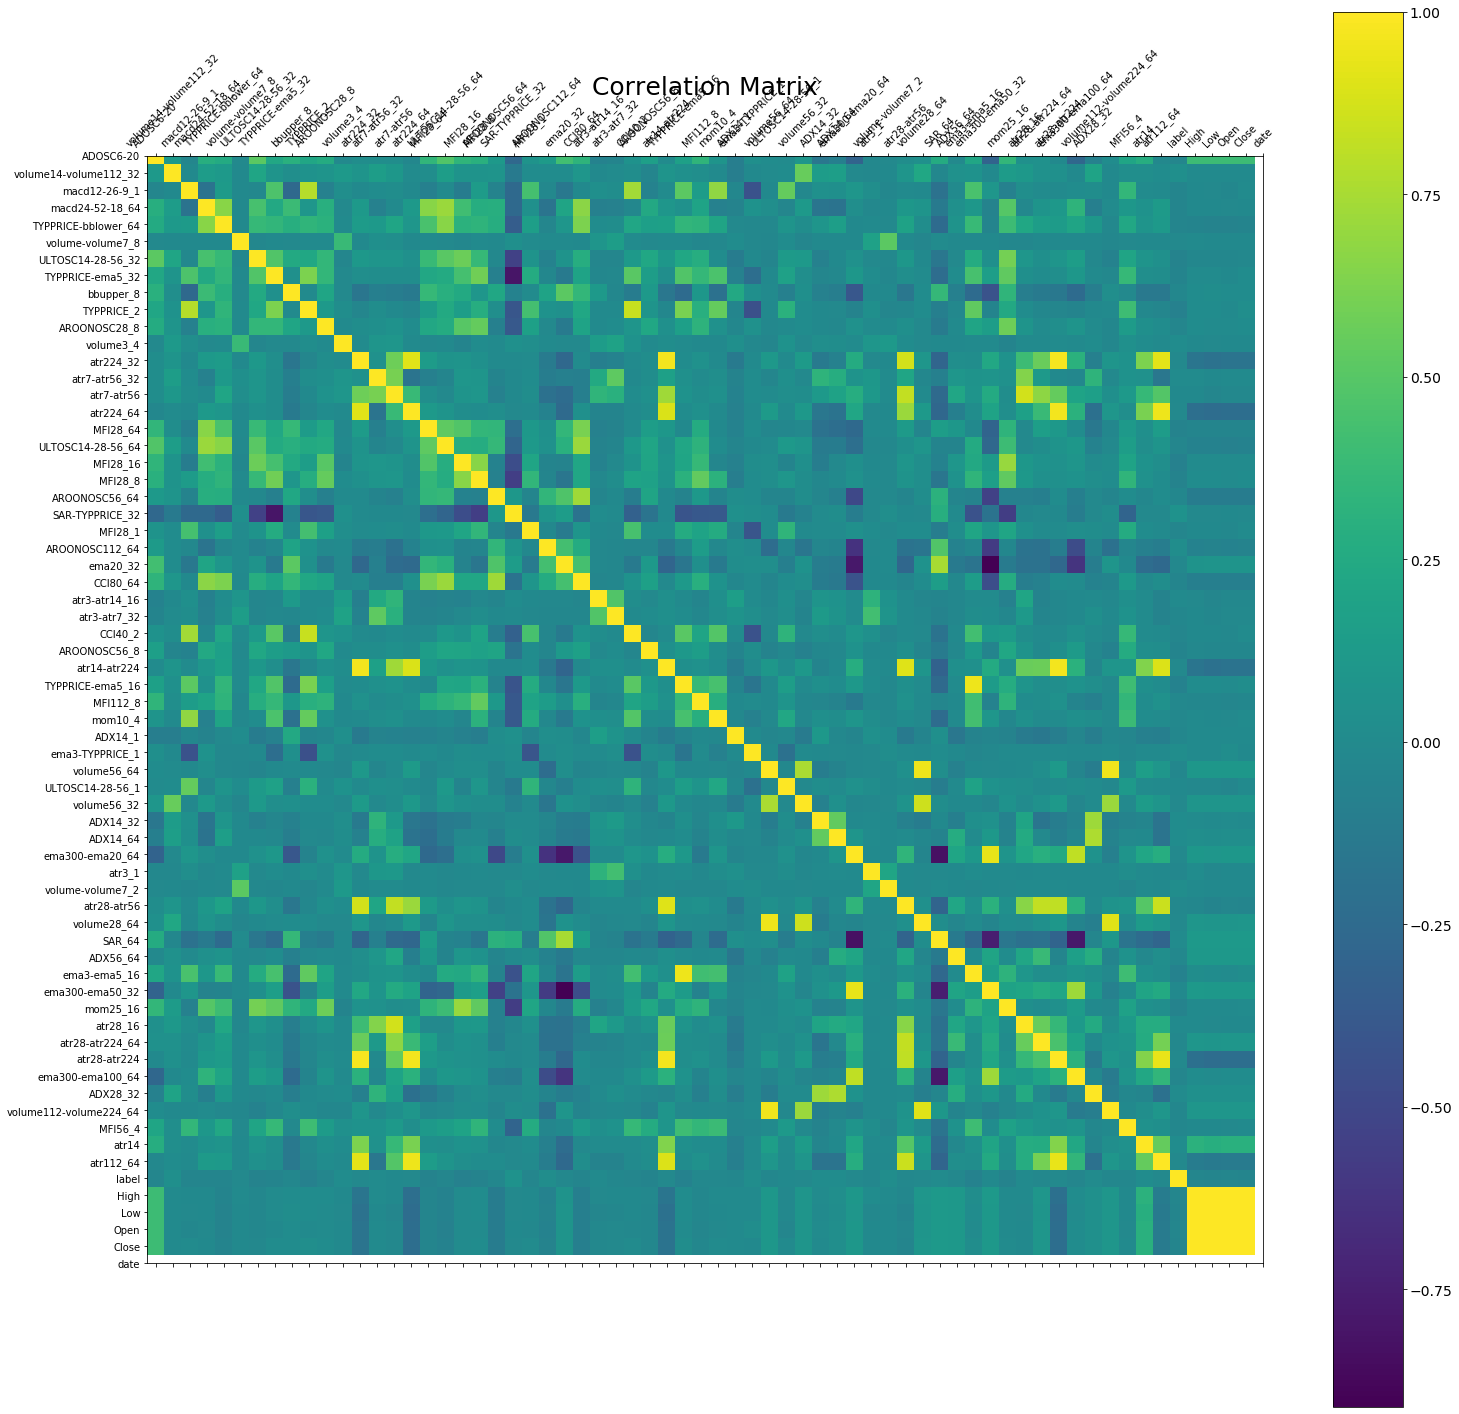

In [15]:
#Correlation Matrix
f = plt.figure(figsize=(25, 25))
plt.matshow(dfDummy.corr(), fignum=f.number)
plt.xticks(range(dfDummy.shape[1]), dfDummy.columns, fontsize=10, rotation=45)
plt.yticks(range(dfDummy.shape[1]), dfDummy.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=25);

In [16]:
#Optuna function for one trial
def objective(trial):
    max_depth = trial.suggest_int('max_depth',2,16)
    num_leaves=trial.suggest_int('num_leaves',10,150)
    learning_rate=trial.suggest_uniform('learning_rate', 0.05, 0.3)
    min_child_samples=trial.suggest_int('min_child_samples', 5, 100)
    reg_lambda=trial.suggest_uniform('lambda', 0.0, 1.0)



    clf = lgb.LGBMClassifier( num_leaves=num_leaves, max_depth=max_depth,
                           learning_rate=learning_rate, n_estimators=3000, 
                           min_child_samples=min_child_samples, reg_lambda=reg_lambda,
                            random_state=0, objective= obj
                           )
    clf.fit(xtrain.drop(columns=colsTempDrop), ytrain,eval_set=[(xtrain.drop(columns=colsTempDrop),ytrain),(xvalid.drop(columns=colsTempDrop),yvalid)],eval_metric=eval_metric,early_stopping_rounds=10,verbose=False )

    ypred = clf.predict(xtest.drop(columns=colsTempDrop))

    backtestdf = xtest.copy()
    backtestdf['label']=ypred
    mn = pd.Series(np.abs(ypred)).median()

    backtest = Backtest(backtestdf, System, commission=comm,margin=.5,cash=100)
    stats = backtest.run()

    #Different scores are applicable to select best strategy.
    score = (stats['SQN']*stats['Return [%]']**2*stats['# Trades'])/stats['Avg. Trade Duration']**2#/((stats['Max. Drawdown Duration'])*np.abs(stats['Avg. Drawdown [%]']))#*stats['# Trades']
#stats['Avg. Trade [%]']*stats['# Trades']**2*
    if(score==0 or np.isnan(score)):
        score=-1000000

    return score

In [17]:
#Find the best trial
optuna.logging.disable_default_handler()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.
Data index is not datetime. Assuming simple periods.


In [18]:
#Get the parameters of best trial.
num_leaves=study.best_trial.params['num_leaves']
learning_rate=study.best_trial.params['learning_rate']
min_child_samples=study.best_trial.params['min_child_samples']
reg_lambda=study.best_trial.params['lambda']

max_depth=study.best_trial.params['max_depth']
n_estimators=3000

In [19]:
#In order to try different models than generated by optuna
#override
# num_leaves=70
# learning_rate=0.07308103631200578
# min_child_samples=84
# reg_lambda=0.07847321290170316
# max_depth=7
# LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#        importance_type='split', learning_rate=0.07308103631200578,
#        max_depth=7, min_child_samples=84, min_child_weight=0.001,
#        min_split_gain=0.0, n_estimators=3000, n_jobs=-1, num_leaves=29,
#        objective=None, random_state=0, reg_alpha=0.0,
#        reg_lambda=0.07847321290170316, silent=True, subsample=1.0,
#        subsample_for_bin=200000, subsample_freq=0)


#Generate model with optuna parameters or overridden parameters.
clf = lgb.LGBMClassifier( num_leaves=num_leaves, max_depth=max_depth,
                       learning_rate=learning_rate, n_estimators=n_estimators, 
                       min_child_samples=min_child_samples, reg_lambda=reg_lambda,
                        random_state=0,objective = obj
                       )
clf.fit(xtrain.drop(columns=colsTempDrop), ytrain,eval_set=[(xtrain.drop(columns=colsTempDrop),ytrain),(xvalid.drop(columns=colsTempDrop),yvalid)],eval_metric=eval_metric,early_stopping_rounds=10,verbose=False )



LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.11347232914166676,
        max_depth=9, min_child_samples=46, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=3000, n_jobs=-1, num_leaves=23,
        objective='multiclass', random_state=0, reg_alpha=0.0,
        reg_lambda=0.07855945148198318, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [20]:
#Experiment for training set and scores.
ypred = clf.predict(xtrain.drop(columns=colsTempDrop))

backtestdf = xtrain.copy()
backtestdf['label']=ypred
mn = pd.Series(np.abs(ypred)).median()
backtest = Backtest(backtestdf.set_index("date"), System, commission=comm,margin=.5,cash=100)
stats = backtest.run()

print('trainStats',stats)
backtest.plot()

trainStats Start                     2011-05-24 23:00:00
End                       2017-07-10 23:00:00
Duration                   2239 days 00:00:00
Exposure [%]                          99.3301
Equity Final [$]                      2013.92
Equity Peak [$]                       2061.65
Return [%]                            1913.92
Buy & Hold Return [%]                 18.5966
Max. Drawdown [%]                    -15.3711
Avg. Drawdown [%]                    -1.72637
Max. Drawdown Duration      123 days 00:00:00
Avg. Drawdown Duration       11 days 00:00:00
# Trades                                  198
Win Rate [%]                          73.2323
Best Trade [%]                        22.1078
Worst Trade [%]                      -3.65808
Avg. Trade [%]                        1.58431
Max. Trade Duration         102 days 00:00:00
Avg. Trade Duration          12 days 00:00:00
Expectancy [%]                        2.13927
SQN                                   6.44181
Sharpe Ratio           

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
Superimposed OHLC plot matches the original plot. Skipping.
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead


In [21]:
#Experiment for validation set and scores.
ypred = clf.predict(xvalid.drop(columns=colsTempDrop))

backtestdf = xvalid.copy()
backtestdf['label']=ypred
mn = pd.Series(np.abs(ypred)).median()
backtest = Backtest(backtestdf.set_index("date"), System, commission=comm,margin=.5,cash=100)
stats = backtest.run()

print('validationStats',stats)
backtest.plot()

validationStats Start                     2017-07-11 23:00:00
End                       2018-11-05 00:00:00
Duration                    481 days 01:00:00
Exposure [%]                          98.1204
Equity Final [$]                      104.401
Equity Peak [$]                       110.038
Return [%]                            4.40137
Buy & Hold Return [%]               0.0438151
Max. Drawdown [%]                    -11.2229
Avg. Drawdown [%]                    -3.41514
Max. Drawdown Duration      230 days 00:00:00
Avg. Drawdown Duration       48 days 00:00:00
# Trades                                   40
Win Rate [%]                               55
Best Trade [%]                         6.9125
Worst Trade [%]                      -4.37195
Avg. Trade [%]                       0.122974
Max. Trade Duration         120 days 00:00:00
Avg. Trade Duration          12 days 00:00:00
Expectancy [%]                          1.476
SQN                                  0.361762
Sharpe Ratio      

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
Superimposed OHLC plot matches the original plot. Skipping.
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead


In [22]:
#Different strategy for backtesting, in order to try different things 
#in test data I used a different class (like ignoring buy orders)
class Test(Strategy):

    def init(self):
        ""
    def next(self):
        if(self.data.label[-1]>0 and not self.position.is_long):
            ""
            self.buy()
        elif(self.data.label[-1]<0 and not self.position.is_short):
            ""
            self.sell()
        elif(self.data.label[-1]==0):
            ""
            self.position.close()

In [23]:
#Experiment for test1 set and scores.
ypred = clf.predict(xtest.drop(columns=colsTempDrop))
backtestdf = xtest.copy()

backtestdf['label']=ypred

backtest = Backtest(backtestdf.set_index("date"), Test, commission=comm,margin=.5,cash=100)
statTest = backtest.run()
print('testStats',statTest)
backtest.plot()

testStats Start                     2018-11-06 00:00:00
End                       2019-07-01 23:00:00
Duration                    237 days 23:00:00
Exposure [%]                          61.3378
Equity Final [$]                       108.46
Equity Peak [$]                       111.517
Return [%]                             8.4605
Buy & Hold Return [%]                 1.23752
Max. Drawdown [%]                    -5.62725
Avg. Drawdown [%]                    -1.71398
Max. Drawdown Duration       55 days 00:00:00
Avg. Drawdown Duration       16 days 00:00:00
# Trades                                   20
Win Rate [%]                               55
Best Trade [%]                        2.99007
Worst Trade [%]                      -1.89434
Avg. Trade [%]                       0.485221
Max. Trade Duration          20 days 00:00:00
Avg. Trade Duration           8 days 00:00:00
Expectancy [%]                        1.20192
SQN                                   1.56934
Sharpe Ratio            

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
Superimposed OHLC plot matches the original plot. Skipping.
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead


In [24]:
#Parameters by importance
print(pd.concat([pd.Series(clf.feature_importances_),pd.Series(xtrain.drop(columns=colsTempDrop).columns)],axis=1).set_index(1).sort_values(0))

                        0
1                        
atr28-atr56             0
ADX14_1                 0
ADX28_32                0
ema3-TYPPRICE_1         0
atr3-atr14_16           0
CCI80_64                0
volume56_64             0
AROONOSC112_64          0
MFI28_1                 0
ULTOSC14-28-56_1        0
AROONOSC56_64           0
MFI28_8                 0
ADX14_32                0
SAR_64                  0
TYPPRICE-ema5_16        0
ema300-ema50_32         0
volume14-volume112_32   0
atr224_32               0
volume3_4               0
AROONOSC28_8            0
atr28-atr224            0
ema3-ema5_16            0
atr7-atr56_32           0
ULTOSC14-28-56_32       0
atr28_16                0
ema300-ema100_64        1
mom10_4                 1
ADX56_64                1
volume56_32             1
volume-volume7_2        1
mom25_16                1
AROONOSC56_8            1
CCI40_2                 1
atr14-atr224            1
macd12-26-9_1           1
macd24-52-18_64         1
TYPPRICE-bbl

In [25]:
#Experiment for test2 set and scores.
ypred = clf.predict(xtestLast.drop(columns=colsTempDrop))

backtestdf = xtestLast.copy()
backtestdf['label']=ypred

backtest = Backtest(backtestdf.set_index("date"), Test, commission=comm,margin=.1,cash=100)
statTest = backtest.run()
print('testStats',statTest)



testStats Start                     2019-07-02 23:00:00
End                       2020-02-28 00:00:00
Duration                    240 days 01:00:00
Exposure [%]                          31.6612
Equity Final [$]                      113.809
Equity Peak [$]                       138.648
Return [%]                            13.8088
Buy & Hold Return [%]                 2.23722
Max. Drawdown [%]                    -25.6216
Avg. Drawdown [%]                    -6.53254
Max. Drawdown Duration      164 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                    2
Win Rate [%]                               50
Best Trade [%]                        17.5505
Worst Trade [%]                      -4.43303
Avg. Trade [%]                        6.55872
Max. Trade Duration          73 days 00:00:00
Avg. Trade Duration          38 days 00:00:00
Expectancy [%]                        10.9918
SQN                                   0.58106
Sharpe Ratio            

In [26]:
backtest.plot()

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead
Superimposed OHLC plot matches the original plot. Skipping.
'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead


In [27]:
#Trying to explain last 20 instances.
dfReal = dfDummy.iloc[-20:]

In [28]:
explainer = shap.TreeExplainer(clf)
explainX = dfReal.drop(columns=colsTempDrop+['label'])
shap_values = explainer.shap_values(explainX)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [29]:
#Instance explanation for the first instance.
shap.force_plot(explainer.expected_value[0], shap_values[0][0], explainX.iloc[0,:])

In [30]:
#Plot of explanations for last 20 instances.
shap.force_plot(explainer.expected_value[0], shap_values[0], explainX)

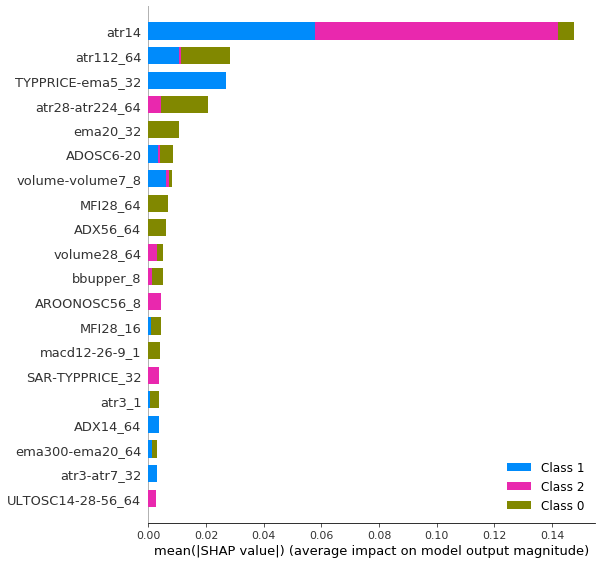

In [31]:
#Explanation model feature importances.
shap.summary_plot(shap_values, x.drop(columns=colsTempDrop))